In [1]:
# Tianyu Lu
# HW1_question2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import random

In [2]:
df = pd.read_csv('classification.csv')
x=df.values[:, 0:2]
y=df.values[:,2]

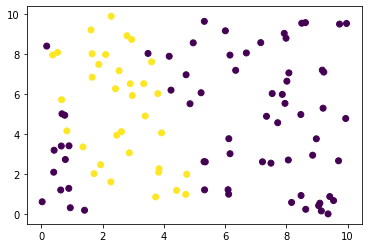

In [3]:
# visualize data
plt.scatter(x[:, 0], x[:, 1],c=y)
plt.show() 

In [4]:
#random.seed(10) #for reproduction

In [5]:
# divide x, y into k list of same size
def getSplitData(x, y, k):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    pList = np.array_split(np.array(arr), k)
    xlist, ylist = [], []
    for fold in pList:
        xlist.append(x[fold])
        ylist.append(y[fold])
    return xlist, ylist

In [6]:
# randomly draw n samples from x, y
def drawSample(x, y, n):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    p1, p2 = arr[:n], arr[n:]
    return x[p1], x[p2], y[p1], y[p2]

In [7]:
# train model with 5-fold cross validation
# returns training performance/loss (normalized)
# model using random forest with 10 trees
def crossValidation(x, y):
    xlist, ylist = getSplitData(x, y, 5)
    accu = []
    for i in range(5):
        model = RandomForestClassifier(n_estimators = 10)
        xtest, ytest = xlist[i], ylist[i]
        xtrain = np.concatenate((xlist[:i] + xlist[i+1:]))
        ytrain = np.concatenate((ylist[:i] + ylist[i+1:]))
        model.fit(xtrain, ytrain)
#         predict = model.predict(xtest)
        accu.append(model.score(xtest, ytest))
    return np.mean(accu)

In [8]:
# train classification model with random sampling
# returns the performance on training and testing set
def ordinarySample(x, y):
    #start with 20 samples at first
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20) # observed and unobserved data
    performance, evaluation = [], []
    while len(xObs) < 50:
        performance.append(crossValidation(xObs, yObs)) # model performance based on cross validation
        model = RandomForestClassifier(n_estimators = 10)
        model.fit(xObs, yObs)
        evaluation.append(model.score(xUnob, yUnob)) # evaluate on unobserved
        # append new samples
        xNew, xUnob, yNew, yUnob = drawSample(xUnob, yUnob, 1)
        xObs = np.concatenate((xObs, xNew))
        yObs = np.concatenate((yObs, yNew))
    return performance, evaluation

In [9]:
# train model with random sampling for 10 simulation
obsAccuracy, unobsAccuracy = [], []
random.seed(120)
for i in range(10):
    print(i)
    perf, eva = ordinarySample(x, y)
    obsAccuracy.append(perf)
    unobsAccuracy.append(eva)
# calculate mean and std for 10 simulation
obsMean = [np.mean(i) for i in np.transpose(np.array(obsAccuracy))]
obsStd = [np.std(i) for i in np.transpose(np.array(obsAccuracy))]
unobsMean = [np.mean(i) for i in np.transpose(np.array(unobsAccuracy))]
unobsStd = [np.std(i) for i in np.transpose(np.array(unobsAccuracy))]

0
1
2
3
4
5
6
7
8
9


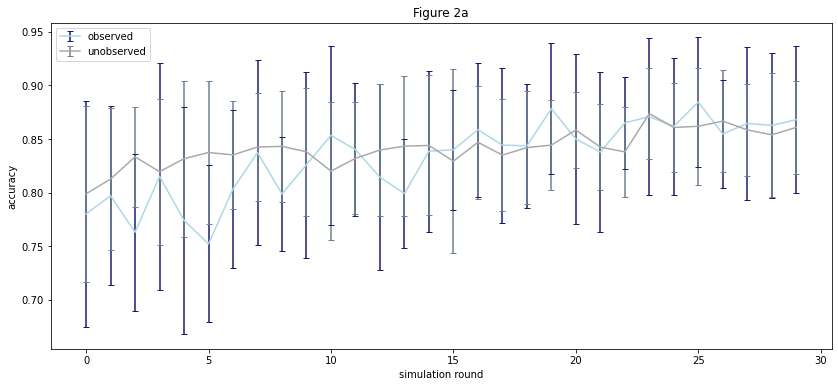

In [10]:
# plot figure for exercise 2-1
xaxis = np.arange(len(obsMean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, obsMean, yerr = obsStd,  label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis, unobsMean, yerr = unobsStd, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

# plt.ylim([0.2,0.6])
plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Figure 2a")
plt.legend()
plt.show()

In [11]:
# pop the sample of least confident
# pop first if tie
def uncertainSample(model, xtest, ytest):
    predProb = model.predict_proba(xtest)
    predConf = [1-max(i) for i in predProb] # calculate confidence for new data
    p = np.argmax(predConf)
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

In [12]:
# train with uncertain sampling
def uncertainTrain(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20)
    performance, evaluation = [], []
    while len(xObs) < 51:
        #print(len(xObs), len(yObs), len(xUnob), len(yUnob))     
        performance.append(crossValidation(xObs, yObs)) #performance with cross-validation
        model = RandomForestClassifier(n_estimators = 10)
        model.fit(xObs, yObs)
        evaluation.append(model.score(xUnob, yUnob)) # evaluate on unobserved
        # append new samples
        xNew, yNew, xUnob, yUnob = uncertainSample(model, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return performance, evaluation
    

In [13]:
# run 10 simulation with uncertainty sampling
obsAccuracy2, unobsAccuracy2 = [], []
for i in range(10):
    perf, eva = uncertainTrain(x, y)
    obsAccuracy2.append(perf)
    unobsAccuracy2.append(eva)
# calculate metrics
obsMean2 = [np.mean(i) for i in np.transpose(np.array(obsAccuracy2))]
obsStd2 = [np.std(i) for i in np.transpose(np.array(obsAccuracy2))]
unobsMean2 = [np.mean(i) for i in np.transpose(np.array(unobsAccuracy2))]
unobsStd2 = [np.std(i) for i in np.transpose(np.array(unobsAccuracy2))]

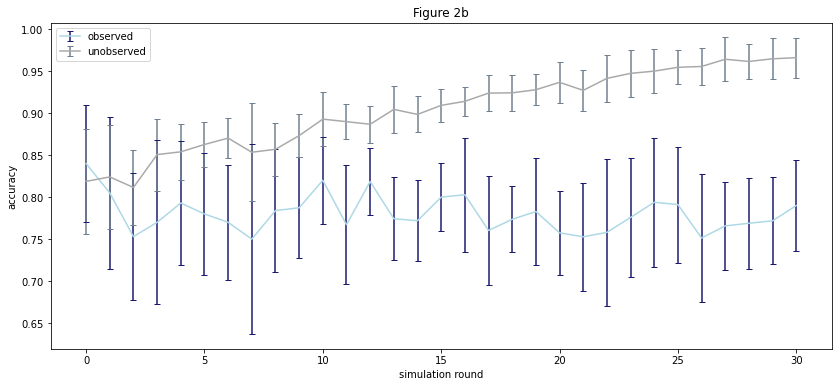

In [15]:
#plot figure for exercise 2-2
xaxis = np.arange(len(obsMean2))
plt.errorbar(xaxis, obsMean2, yerr = obsStd2, label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis, unobsMean2, yerr = unobsStd2, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

# plt.ylim([0.2,0.6])
plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Figure 2b")
plt.legend()
plt.show()